In [79]:
import os
import torch
import torchvision
import torch.utils.data as data
from torch.utils.data.dataset import Dataset as Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn

from torch.autograd import Variable 
from glob import glob
from PIL import Image

%matplotlib inline 

In [77]:
#os.getcwd()
DATA_PATH = '../DeepLearningDataset/Kaggle_Carvana_Masking_Challenge/dataset'

TRAIN_DATA_PATH = glob('/'.join([DATA_PATH,'train/*.jpg']))
TRAIN_MASKS_PATH = glob('/'.join([DATA_PATH,'train_masks/*.gif']))
TEST_PATH = glob('/'.join([DATA_PATH,'test/*.jpg']))

TRANSFORM = transforms.Compose([transforms.ToTensor()])    

In [34]:
print(TRAIN_MASKS_PATH[0])
print(TRAIN_DATA_PATH[0])

../DeepLearningDataset/Kaggle_Carvana_Masking_Challenge/dataset/train_masks/00087a6bd4dc_01_mask.gif
../DeepLearningDataset/Kaggle_Carvana_Masking_Challenge/dataset/train/00087a6bd4dc_01.jpg


In [49]:
len(TRAIN_DATA_PATH)

5088

In [33]:
TRAIN_DATA_PATH.sort()
TRAIN_MASKS_PATH.sort()
TEST_PATH.sort()

In [0]:
class CarvanaDataset(Dataset):
    def __init__(self,train_path,masks_path):
        self.train_path = train_path 
        self.masks_path = masks_path

    def transforms(self,image,mask):
        image = image.resize((64, 64), PIL.Image.NEAREST)
        mask = mask.resize((64, 64), PIL.Image.NEAREST)
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return(image,mask)

    def __getitem__(self,index):
        image = Image.open(self.train_path[index])
        mask  = Image.open(self.masks_path[index])

        x,y = self.transforms(image,mask)
        return(x,y)
   
    def __len__(self):
        return(len(self.train_path))


In [0]:
Train_Dataset  = CarvanaDataset(TRAIN_DATA_PATH,TRAIN_MASKS_PATH)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1918x1280 at 0x131E529D0>


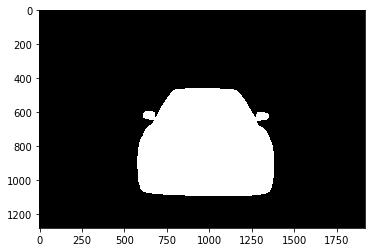

In [47]:
im, mask = Train_Dataset[0]
#im = im.numpy()
print(im)
#mask = mask.numpy()
#prod = np.multiply(im, mask)
#print(prod.shape)
#plt.imshow(im)
plt.imshow(mask)

In [93]:
#BATCH_SIZE = len(TRAIN_DATA_PATH)*0.05
BATCH_SIZE = 10

train_data_loader = data.DataLoader(dataset=Train_Dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)


### Defining UNet Architecture 

In [83]:

def double_conv(in_channels,out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=0),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=0),
        nn.ReLU(inplace=True)
    )

In [84]:
class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)  

        self.maxpool = nn.MaxPool2d(2)
        
        self.dconv_up3 = double_conv(512, 256)
        self.dconv_up2 = double_conv(256, 128)
        self.dconv_up1 = double_conv(128, 64)
        
        self.TConv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.TConv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.TConv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        x = self.dconv_down4(x)
        
        x = self.TConv3(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.TConv2(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.TConv1(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)
        out = self.conv_last(x)
        out = F.sigmoid(out)
        
        return out

In [94]:
model = UNet(n_class=1)
optimizer = optim.Adam(model.parameters(), lr=3e-5)
criterion = nn.BCELoss()
model.train()

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dconv_up3): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3

In [95]:
EPOCHS = 3
running_loss = 0.0 

model.train()

for epoch in range(EPOCHS):
    loss = 0.0 
    for i, (x,y) in enumerate(train_data_loader):
        print(i)
        X = Variable(x)
        Y = Variable(y)

        optimizer.zero_grad()
        output = model(X)

        loss = criterion(ouput,Y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print("loss for epoch " + str(epoch) + ":  " + str(running_loss))


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/rahulm/anaconda/envs/dl/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/rahulm/anaconda/envs/dl/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/Users/rahulm/anaconda/envs/dl/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 81, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>


### 